# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.manifold import TSNE
import torchvision.transforms as T
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
!nvidia-smi

Thu Jan  5 08:43:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    33W /  70W |      3MiB / 15109MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))


    print(len(all_photos.values))
    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
def swap_dims(img):
    if img.shape[0] == 3:
        return np.rollaxis(img, 0, 3)
    elif img.shape[0] == 1:
        return img[0]
    return img

def plot_images(n_rows, n_cols, first_line, first_title=None, second_line=[], second_title=None, third_line=[], third_title=None, plt_title=None):
    plt.figure(figsize=(20, 10))
    if len(third_line) != 0:
        for i in range(n_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.axis("off")
            plt.imshow(swap_dims(first_line[i]))
            if first_title is not None:
                plt.title(first_title)

            plt.subplot(n_rows, n_cols, i + n_cols + 1)
            plt.imshow(swap_dims(second_line[i]))
            if second_title is not None:
                plt.title(second_title)
            plt.axis('off')

            plt.subplot(n_rows, n_cols, i + 2 * n_cols + 1)
            plt.imshow(swap_dims(third_line[i]))
            if third_title is not None:
                plt.title(third_title)
            plt.axis('off')
    if len(second_line) != 0:
        for i in range(n_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.axis("off")
            plt.imshow(swap_dims(first_line[i]))
            if first_title is not None:
                plt.title(first_title)

            plt.subplot(n_rows, n_cols, i + n_cols + 1)
            plt.imshow(swap_dims(second_line[i]))
            if second_title is not None:
                plt.title(second_title)
            plt.axis('off')
    else:
        for i in range(n_rows * n_cols):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.axis("off")
            plt.imshow(swap_dims(first_line[i]))
            if first_title is not None:
                plt.title(first_title)
            plt.axis('off')
    if plt_title:
        plt.suptitle(plt_title)
    plt.show()

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done
13143



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
batch_size=32
train_loader = torch.utils.data.DataLoader(np.rollaxis(train_photos, 3, 1), batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(np.rollaxis(val_photos, 3, 1), batch_size=batch_size)
     

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


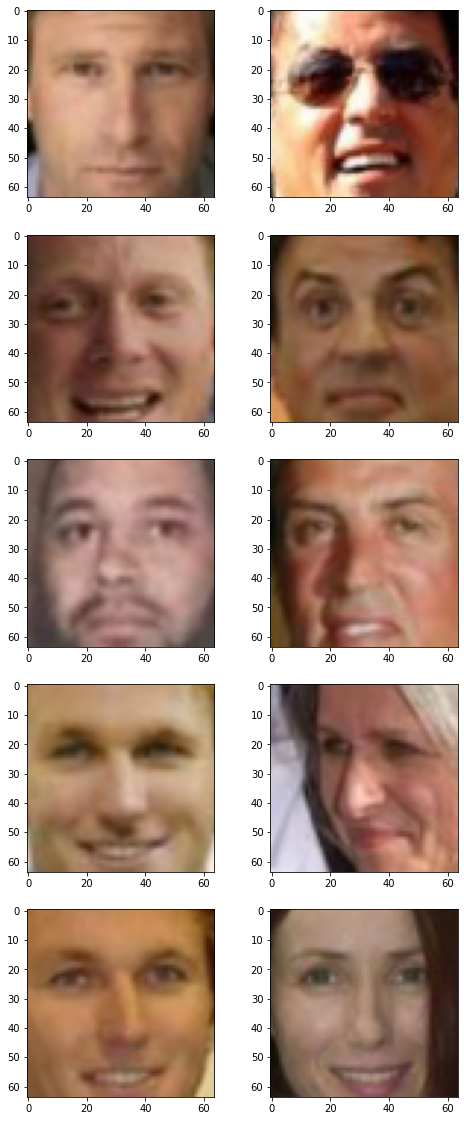

In [ ]:
plt.figure(figsize=(8, 20))
for i, (photo_tr,photo_val) in enumerate(zip(train_photos[:5],val_photos[:5])):
  print(photo_val.shape)
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(photo_tr)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(photo_val)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim = 64):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.encoder_flatten = nn.Flatten()
        self.encoder_fc = nn.Linear(64 * 64 * 64, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, 64 * 64 * 64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
        )

    def encode(self, x):
        latent = self.encoder_conv(x)
        latent = self.encoder_flatten(latent)
        latent = self.encoder_fc(latent)
        return latent
    
    def decode(self, x):
        restor = self.decoder_fc(x)
        restor = restor.view(-1, 64, 64, 64)
        restor = self.decoder(restor)
        restor = torch.sigmoid(restor)
        return restor
    
    def forward(self, x):      
        latent = self.encode(x)
        restor = self.decode(latent)

        return restor, latent

In [ ]:
criterion = F.mse_loss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = Autoencoder().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.3)

## 1.3 Обучение (2 балла)

In [ ]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        reconstruction, latent = autoencoder(batch)
        #reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.float(), reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          batch = batch.to(device)
          reconstruction, latent = autoencoder(batch)
          #reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(batch.float(), reconstruction)
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

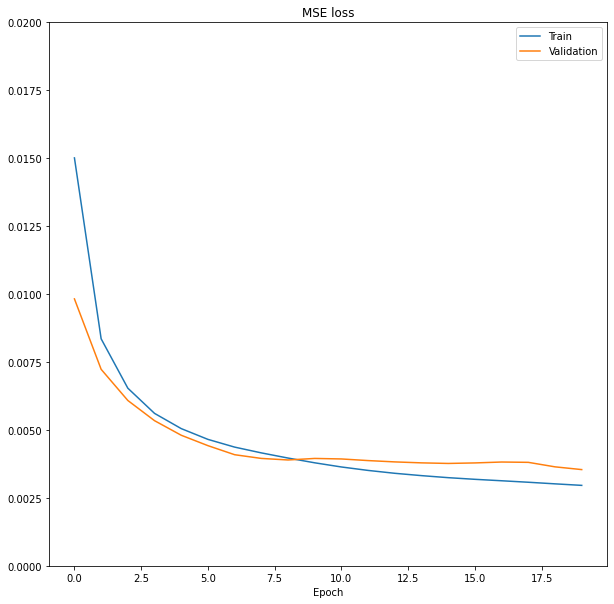

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(0, 0.02)
plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()
plt.grid = True

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def predict(autoencoder, val_loader):
    rest, lat = [], []
    autoencoder.eval()
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.to(device)
            restor, latent = autoencoder(X_batch)
            rest.append(restor.cpu())
            lat.append(latent.cpu())
    
    return torch.cat(rest), torch.cat(lat)

In [ ]:
restore, latent = predict(autoencoder, val_loader)

In [ ]:
real = next(iter(val_loader))

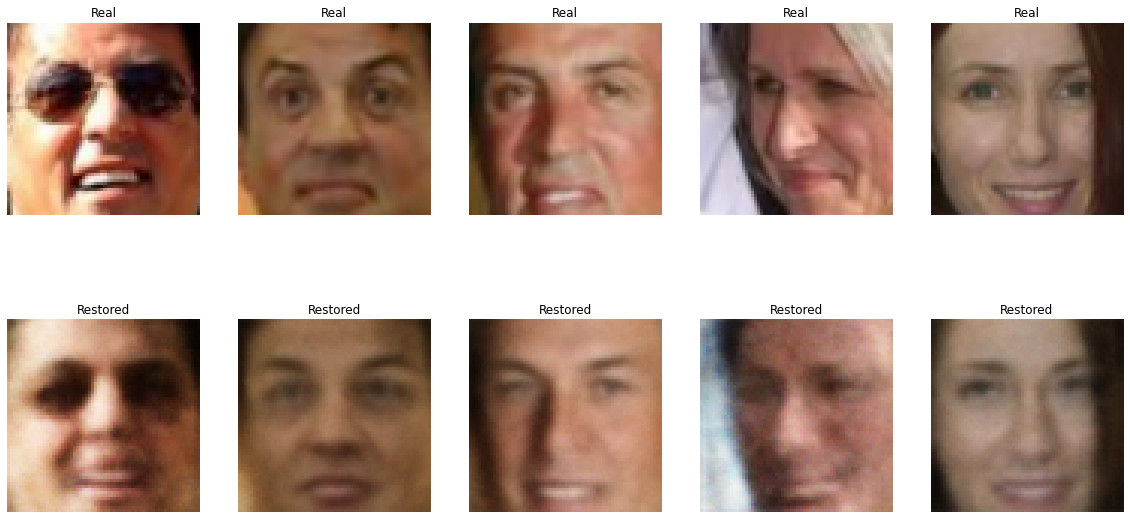

In [ ]:
plot_images(2, 5, real[:5].numpy(), "Real", restore[:5].numpy(), "Restored")

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 64)
z = torch.tensor(z, dtype=torch.float32).to(device)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(z).cpu()

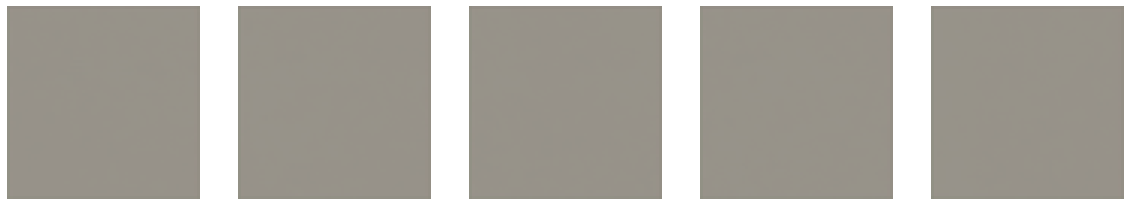

In [ ]:
plot_images(1, 5, output[:5].numpy())

# Найдем моменты распределения латентых векторов

In [ ]:
mean = torch.mean(latent,0)
std = torch.std(latent,0) 

Построим 25 случайных векторов построенных по распределению с полученными выше параметрами

In [ ]:
latent_random = torch.cat([(mean + (torch.randn_like(mean)*std)).view(1, -1) for _ in range(25)]).to(device)

In [ ]:
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.decode(latent_random).cpu()

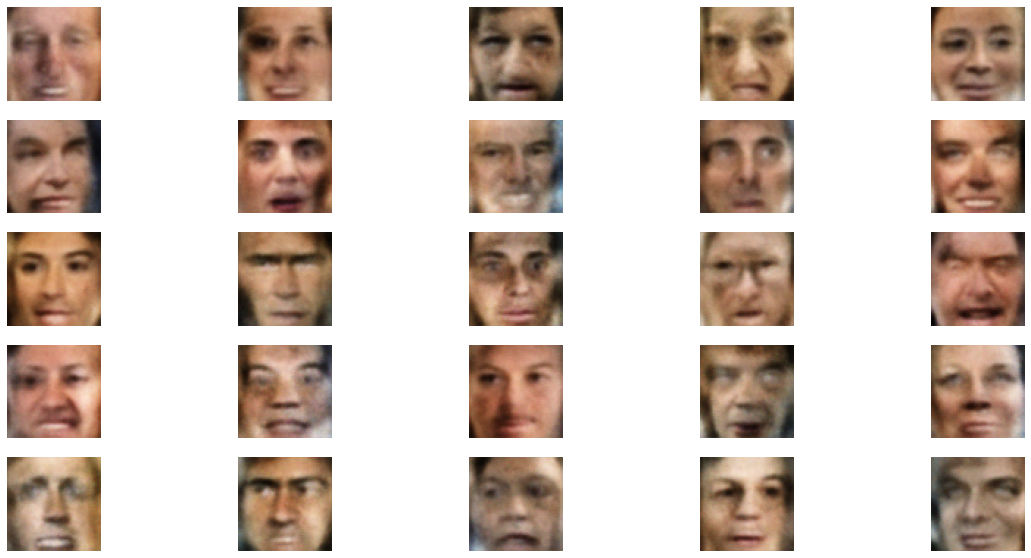

In [ ]:
plot_images(5, 5, output.numpy())

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

работаем с файлом
⚓

In [ ]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [ ]:
attrs['Smiling'].sort_values(ascending=False).head(15).index.values

array([ 8643,  1816, 13034,  5624,  1045,  4681,  6139, 11797,  1359,
        2031,  1955,  9004,   459,  6166,   682])

In [ ]:

smiling_ind = attrs['Smiling'].sort_values(ascending=False).head(15).index.values
smiling_faces = data[smiling_ind]


In [ ]:
smiling_faces.shape

(15, 64, 64, 3)

In [ ]:
non_smiling_ind = attrs['Smiling'].sort_values().head(15).index.values
non_smiling_faces = data[non_smiling_ind]

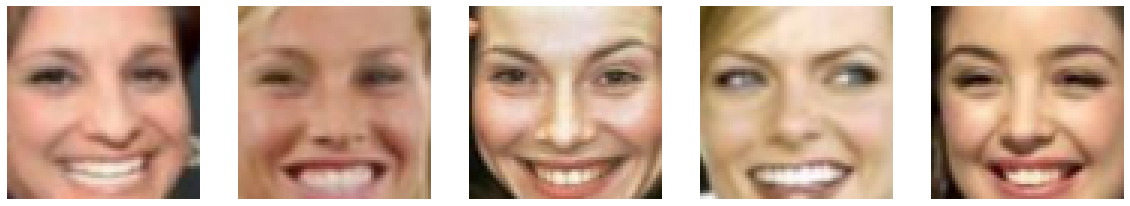

In [ ]:
plot_images(1, 5, smiling_faces[:5])

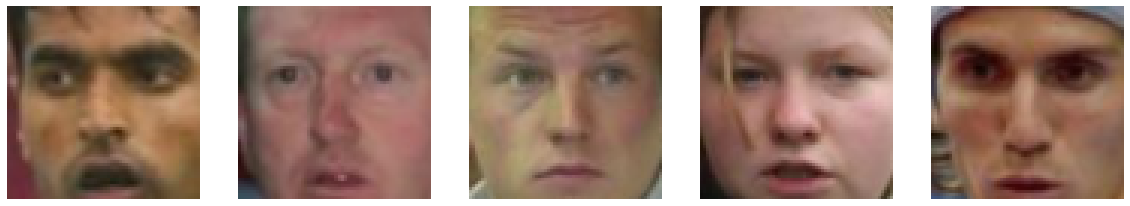

In [ ]:
plot_images(1, 5, non_smiling_faces[:5])

Нашли латентное представление для лиц с улыбкой

In [ ]:
with torch.no_grad():
    smile_tensor = torch.tensor(np.rollaxis(smiling_faces, 3, 1), dtype=torch.float32)
    smile_tensor = smile_tensor.to(device)
    autoencoder.eval()
    latent_smile = autoencoder.encode(smile_tensor).cpu()

Нашли латентное представление для лиц без улыбки

In [ ]:
with torch.no_grad():
    non_smile_tensor = torch.tensor(np.rollaxis(non_smiling_faces, 3, 1), dtype=torch.float32)
    non_smile_tensor = non_smile_tensor.to(device)
    autoencoder.eval()
    latent_non_smile = autoencoder.encode(non_smile_tensor).cpu()

In [ ]:
mean_smile = torch.mean(latent_smile,0)
mean_non_smile = torch.mean(latent_non_smile,0)

Найдем вектор улыбки

In [ ]:
mime = mean_smile - mean_non_smile

In [ ]:
mime.shape

torch.Size([64])

In [ ]:
with torch.no_grad():
    autoencoder.eval()
    decode_smile = autoencoder.decode(mime.to(device)).cpu()

Пририсовываем улыбку печальным людям)

In [ ]:
with torch.no_grad():
    non_smile_tensor = torch.tensor(np.rollaxis(non_smiling_faces, 3, 1), dtype=torch.float32)
    non_smile_tensor = non_smile_tensor.to(device)
    autoencoder.eval()
    latent_non_smile = autoencoder.encode(non_smile_tensor).cpu()

In [ ]:
latent_non_smile.shape

torch.Size([15, 64])

In [ ]:
with_mime = latent_non_smile  + mime

In [ ]:
with torch.no_grad():
    autoencoder.eval()
    decode_with_mime = autoencoder.decode(with_mime.to(device)).cpu()
    decode_without_mime = autoencoder.decode(latent_non_smile.to(device)).cpu()

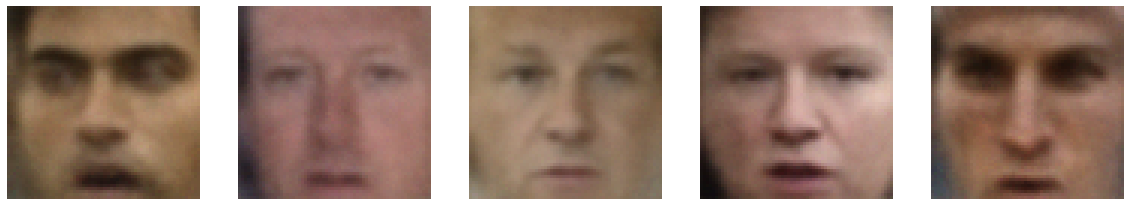

In [ ]:
plot_images(1, 5, decode_without_mime[:5].numpy())

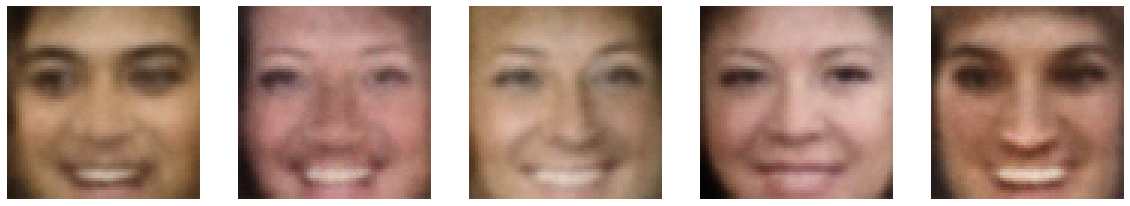

In [ ]:
plot_images(1, 5, decode_with_mime[:5].numpy())

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import datasets, transforms

In [ ]:
batch_size = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent=64):
        super().__init__()
        if latent % 2 != 0: # check for the parity of the latent space
             raise Exception("Latent size for VAEEncoder must be even")

        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )


        self.mu_fc = nn.Linear(256, latent*2)
        self.log_sigma_fc = nn.Linear(256, latent)

        self.decoder = nn.Sequential(
            nn.Linear(latent, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
        )

    def encode(self, x):
        flattened = self.encoder_flatten(x)
        encoded = self.encoder(flattened)
        latent = self.mu_fc(encoded)
        size = latent.shape[1] // 2 # divide the latent representation into mu and log_var
        mu = latent[:, :size] 
        log_sigma = latent[:, size:] 
        return mu, log_sigma
    
    def gaussian_sampler(self, mu, log_sigma):
        if self.training:
            std = torch.exp(0.5 * log_sigma)
            eps = torch.randn_like(std)      
            return mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        
        return reconstruction

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        z = self.gaussian_sampler(mu, log_sigma)
        reconstruction = self.decode(z)
        
        return mu, log_sigma, reconstruction

Пробовал реализовать VAE со свертками, но он оказался гораздо хуже в этой задаче

In [ ]:
# class VAE(nn.Module):
#     def __init__(self, latent_dim=64):
#        super().__init__()
#        if latent_dim % 2 != 0: # check for the parity of the latent space
#             raise Exception("Latent size for VAEEncoder must be even")
      
#        self.encoder_conv = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#         )

#        self.encoder_flatten = nn.Flatten()
#        self.encoder_fc = nn.Linear(32 * 28 * 28, latent_dim * 2)
#        self.decoder_fc = nn.Linear(latent_dim, 32 * 28 * 28)

#        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),)
        

#     def encode(self, x):
#         latent = self.encoder_conv(x)
#         latent = self.encoder_flatten(latent)
#         latent = self.encoder_fc(latent)
#         size = latent.shape[1] // 2 # divide the latent representation into mu and log_var
#         mu = latent[:, :size] 
#         log_sigma = latent[:, size:] 
#         return mu, log_sigma
        
#     def gaussian_sampler(self, mu, log_sigma):
#         if self.training:
#             sigma = torch.exp(0.5 * log_sigma).to(device)
#             z = torch.randn(mu.shape[0], mu.shape[1]).to(device)
#             return z*sigma + mu
#         else:
#             # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
#             # на инференсе выход автоэнкодера должен быть детерминирован.
#             return mu
    
#     def decode(self, z):
#         restor = self.decoder_fc(z)
#         restor = restor.view(-1, 32, 28, 28)
#         restor = self.decoder(restor)
#         restor = torch.sigmoid(restor)
#         return restor
        

#     def forward(self, x):
#         mu, log_sigma = self.encode(x)
#         z = self.gaussian_sampler(mu, log_sigma)
#         reconstruction = self.decode(z)
#         return mu, log_sigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    KLD = KL_divergence(mu, logsigma)
    BCE = log_likelihood(x, reconstruction)
    return KLD + BCE

И обучим модель:

In [ ]:
criterion = loss_vae

vae = VAE().to(device)
optimizer = optim.AdamW(vae.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
n_epochs = 20
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    vae.train()
    train_losses_per_epoch = []
    for batch, lst in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        mu, log_sigma, reconstruction = vae(batch)
        #reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(batch.float().to(device),mu, log_sigma.to(device),reconstruction.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    print(loss)
    train_losses.append(np.mean(train_losses_per_epoch))

    vae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, lst in tqdm(test_loader):
          batch = batch.to(device)
          mu, log_sigma, reconstruction = vae(batch)
          #reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(batch.to(device).float(),mu.to(device), log_sigma.to(device),reconstruction.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    scheduler.step()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(18213.5117, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(14983.6426, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(13485.5664, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(12943.6904, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11975.0566, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11974.2773, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11515.5088, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11837.3955, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11753.1328, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11486.4121, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11038.1289, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11111.1465, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11194.9336, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11439.9443, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11123.7285, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11271.2002, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10923.4014, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10768.3350, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10055.3174, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10664.2207, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
def predict_vae(vae, test_loader):
    rest, all_mu, all_log_sigma = [], [], []
    vae.eval()
    with torch.no_grad():
        for batch,_ in test_loader:
            batch = batch.to(device)
            mu, log_sigma, reconstruction = vae(batch)
            rest.append(reconstruction.cpu())
            all_mu.append(mu.cpu())
            all_log_sigma.append(log_sigma.cpu())
    
    return torch.cat(rest),torch.cat(all_mu),torch.cat(all_log_sigma)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
reconstructions, all_mu, all_log_sigma = predict_vae(vae, test_loader)

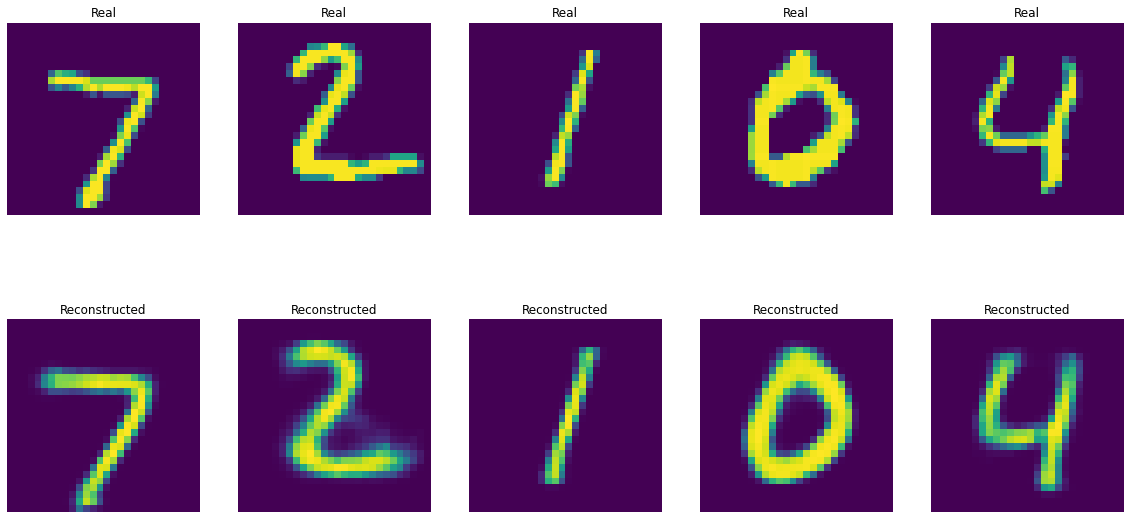

In [ ]:
real = next(iter(test_loader))[0]
plot_images(2, 5, real[:15].numpy(), "Real", reconstructions[:15].numpy(), "Reconstructed")

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 64) for i in range(10)])
z = torch.tensor(z, dtype=torch.float32).to(device)
output = vae.decode(z)
     

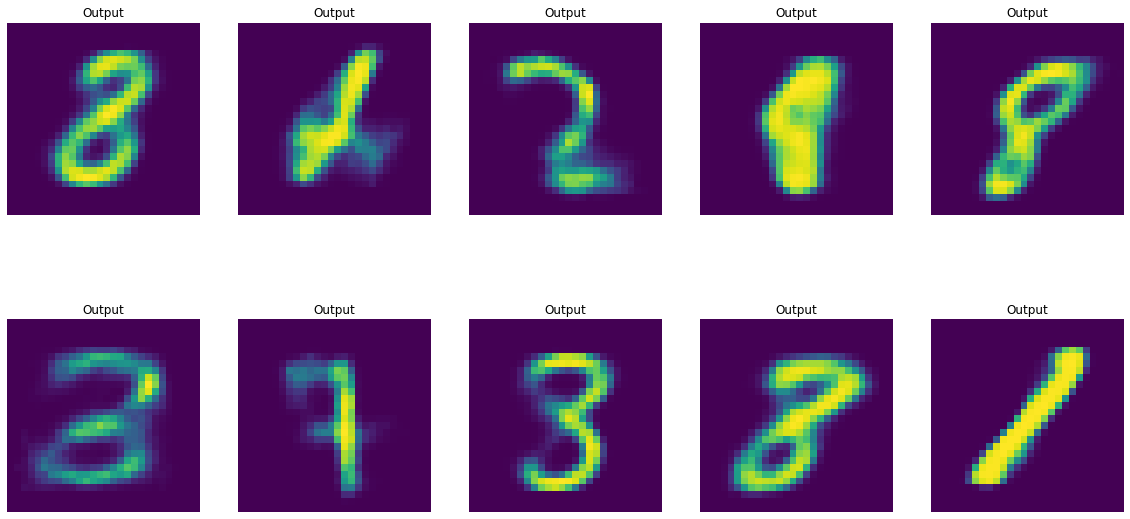

In [ ]:
plot_images(2, 5, output[:10].cpu().detach().numpy(), "Output")

Волне неплохо

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


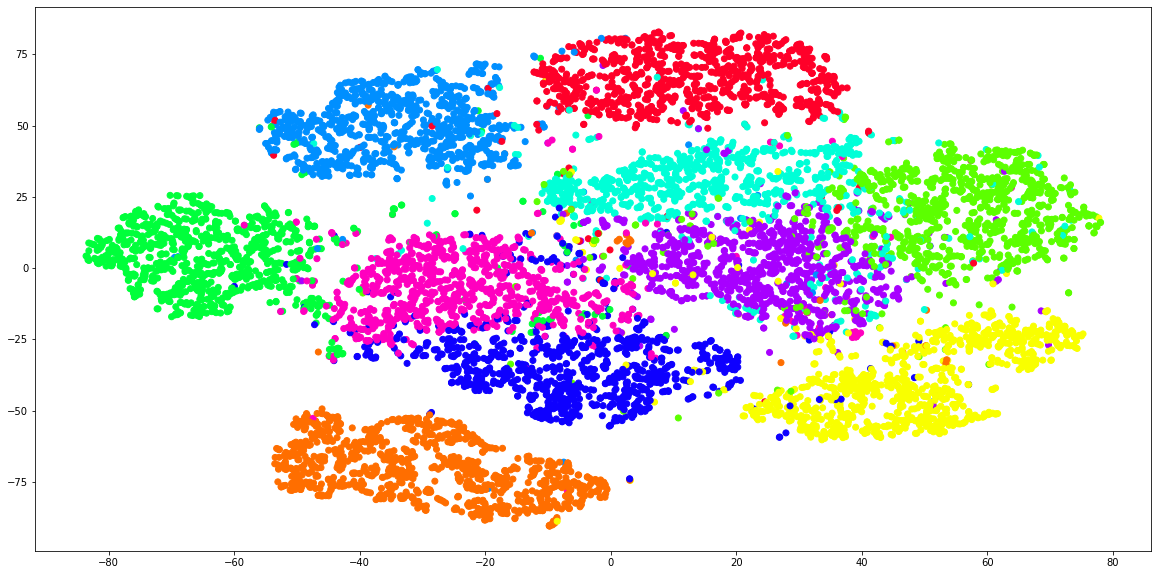

In [ ]:

all_mu_transformed = torch.from_numpy(TSNE(n_components=2).fit_transform(all_mu))

plt.figure(figsize=(20, 10))
plt.scatter(all_mu_transformed[:, 0], all_mu_transformed[:, 1], c=test_dataset.targets, cmap='gist_rainbow')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.


Попробую использовать линейные слои, чтобы было меньше проблем с конкатенациями

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()

        self.encoder_flatten = nn.Flatten(start_dim=1)
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28 + 10, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )


        self.mu_fc = nn.Linear(256, latent_dim)
        self.logsigma_fc = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 10, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
        )

    def encode(self, x, y):
        flattened = self.encoder_flatten(x)
        flattened = torch.cat((flattened, y), dim=1)
        encoded = self.encoder(flattened)

        mu = self.mu_fc(encoded)
        logsigma = self.logsigma_fc(encoded)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)      
            return mu + (eps * std)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, y):
        reconstruction = torch.cat((z, y), dim=1)
        reconstruction = self.decoder(reconstruction)
        reconstruction = torch.sigmoid(reconstruction)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        
        return reconstruction

    def forward(self, x, class_num):
        y = nn.functional.one_hot(class_num, 10)
        mu, logsigma = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)
        
        return mu, logsigma, reconstruction

In [ ]:
criterion = loss_vae

cvae = CVAE().to(device)

optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


In [ ]:
n_epochs = 10
train_losses = []
val_losses = []

for epoch in tqdm(range(n_epochs)):
    cvae.train()
    train_losses_per_epoch = []
    for x_batch, target  in tqdm(train_loader):
        x_batch = x_batch.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        mu, log_sigma, reconstruction = cvae(x_batch, target)
        #reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(x_batch.to(device).float(),mu.to(device), log_sigma.to(device),reconstruction.to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    print(loss)
    train_losses.append(np.mean(train_losses_per_epoch))

    cvae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for x_batch, target in tqdm(test_loader):
          x_batch = x_batch.to(device)
          target = target.to(device)
          mu, log_sigma, reconstruction = cvae(x_batch, target)
          #reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(x_batch.to(device).float(),mu.to(device), log_sigma.to(device),reconstruction.to(device))
          val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    scheduler.step()
    




  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(14260.5342, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(12361.4307, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11647.7969, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(12407.4121, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10789.1953, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11297.3701, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10693.9004, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10395.7529, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(11140.7568, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

tensor(10683.9150, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

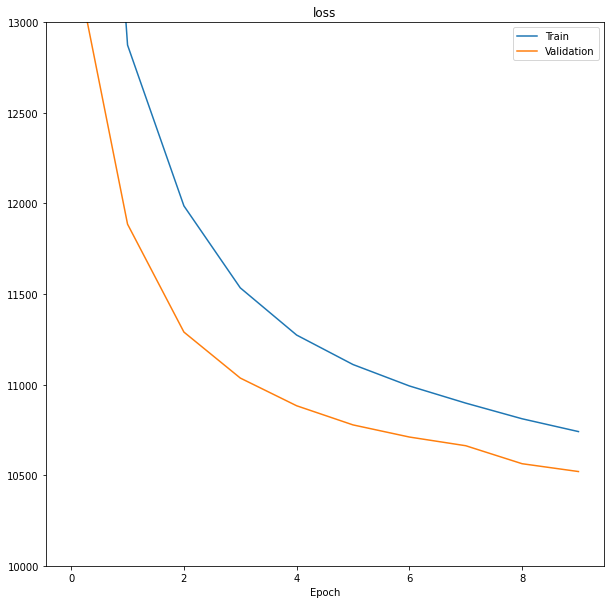

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.ylim(10000, 13000)
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()
plt.grid = True

In [ ]:
def predict_cvae(cvae, test_loader):
    reconstructions, all_mu, all_log_sigma = [], [], []
    cvae.eval()
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            mu, logsigma, reconstructed = cvae(X_batch, Y_batch)
            reconstructions.append(reconstructed.cpu())
            all_mu.append(mu.cpu())
            all_log_sigma.append(logsigma.cpu())
    
    return torch.cat(reconstructions), torch.cat(all_mu), torch.cat(all_log_sigma)

In [ ]:
reconstructions, all_mu, all_log_sigma = predict_cvae(cvae,test_loader)

Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
cvae.eval()
y = nn.functional.one_hot(torch.LongTensor([5]), 10).view(1, -1)
with torch.no_grad():
    reconstructions = np.array([cvae.decode(all_mu[i].view(1, -1).to(device), y.to(device)).cpu().numpy() for i in range(5)]).squeeze()
real = next(iter(test_loader))[0]

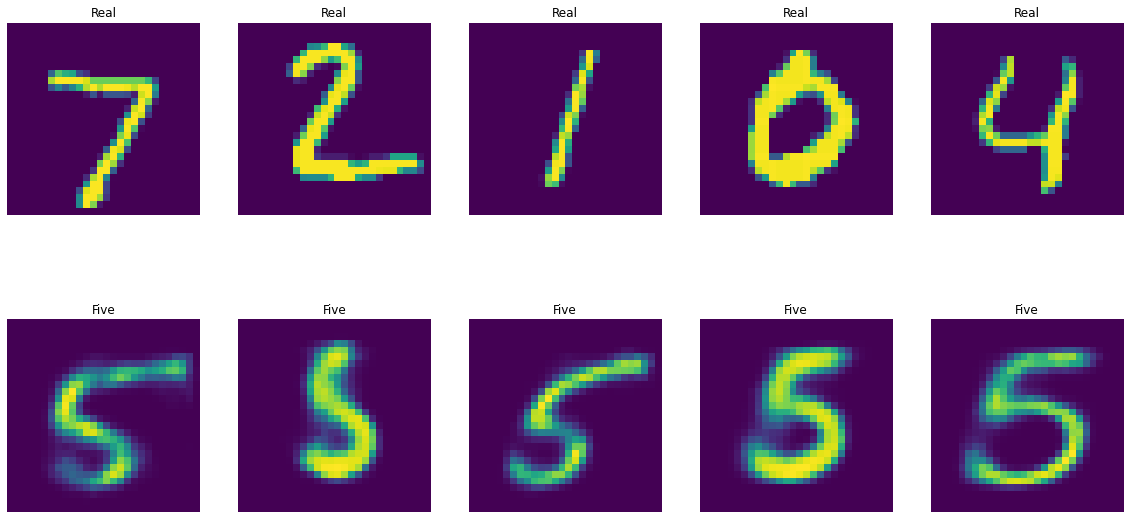

In [ ]:

plot_images(2, 5, real[:5].numpy(), "Real", reconstructions[:5], "Five")

In [ ]:
cvae.eval()
y = nn.functional.one_hot(torch.LongTensor([9]), 10).view(1, -1)
with torch.no_grad():
    reconstructions = np.array([cvae.decode(all_mu[i].view(1, -1).to(device), y.to(device)).cpu().numpy() for i in range(5)]).squeeze()
real = next(iter(test_loader))[0]

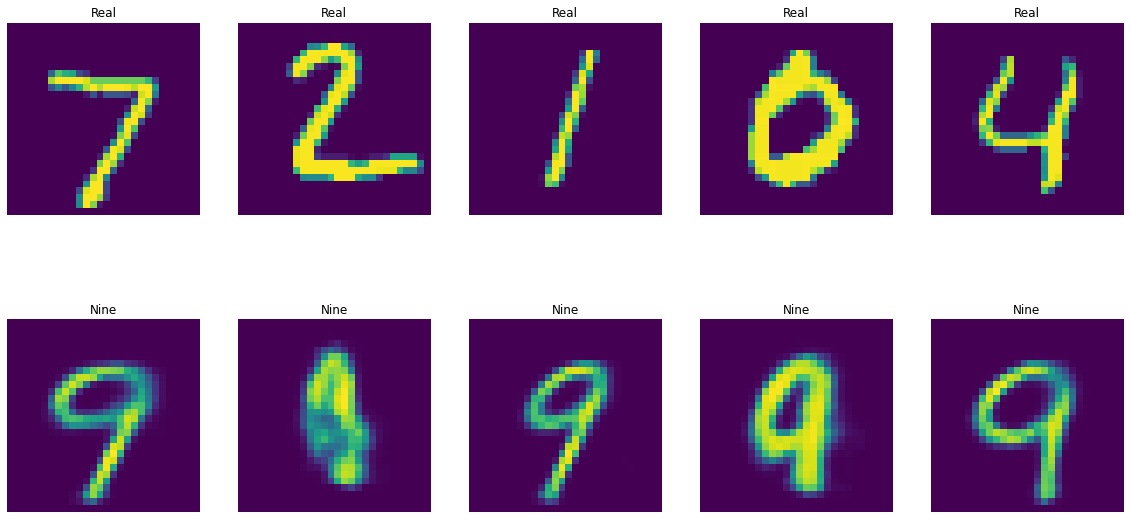

In [ ]:
plot_images(2, 5, real[:5].numpy(), "Real", reconstructions[:5], "Nine")

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


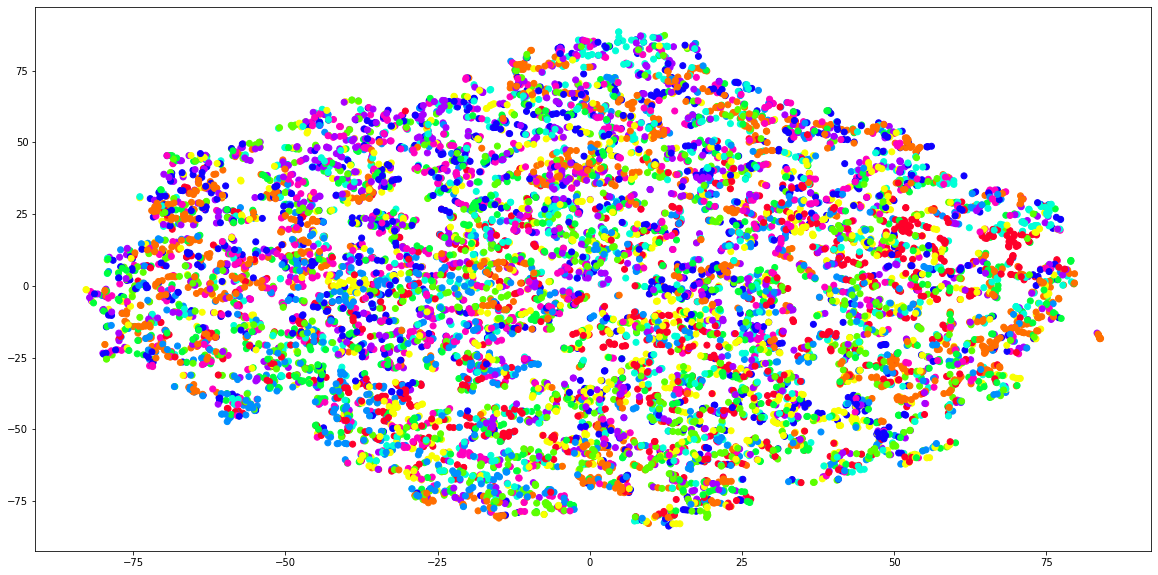

In [ ]:
all_mu_transformed = torch.from_numpy(TSNE(n_components=2).fit_transform(all_mu))

plt.figure(figsize=(20, 10))
plt.scatter(all_mu_transformed[:, 0], all_mu_transformed[:, 1], c=test_dataset.targets, cmap='gist_rainbow')